## Set Up:

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from random import choices
import math
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
%matplotlib inline

from statsmodels.stats.power import ttest_power, tt_ind_solve_power
from ab_testing.predictions.produce_predictions import ProducePredictions
from bayesian_testing.experiments import BinaryDataTest, DeltaLognormalDataTest

from ml_lib.feature_store import configure_offline_feature_store
from ml_lib.feature_store.offline.client import FeatureStoreOfflineClient
configure_offline_feature_store(
    workgroup="primary"
)

In [3]:
def eval_data_seq(
    data_df,
    stop_rule_con: int,
    stop_rule_rev: int,
    
    a_prior_conv_test_C: int = 1,
    b_prior_conv_test_C: int = 1,
    a_prior_conv_test_P: int = 1,
    b_prior_conv_test_P: int = 1,
    
    a_prior_beta_revenue_test_P: int = 1,
    b_prior_beta_revenue_test_P: int = 1,
    m_prior_revenue_test_P: int = 2,
    a_prior_ig_revenue_test_P: int = 10,
    b_prior_ig_revenue_test_P: int = 20,
    w_prior_revenue_test_P: int = 10,
    
    a_prior_beta_revenue_test_C: int = 1,
    b_prior_beta_revenue_test_C: int = 1,
    m_prior_revenue_test_C: int = 2,
    a_prior_ig_revenue_test_C: int = 10,
    b_prior_ig_revenue_test_C: int = 20,
    w_prior_revenue_test_C: int = 10,
) -> list:
    trial = 0
    start_date = min(data_df.meta_date).to_pydatetime()
    end_date = max(data_df.meta_date).to_pydatetime()
    dates_list = [(start_date + timedelta(days=x)) for x in range((end_date-start_date).days + 1)]
    
    con_results = []
    rev_results = []
    
    for current_date in dates_list:
        print(current_date)
        try:
            daily_data = data_df[data_df.meta_date == current_date].copy()
            daily_data['conversions'] = daily_data['total_wins_spend'] > 0
            df_P = daily_data.loc[
                (daily_data["test_group"].str.lower() == "p") | (daily_data["test_group"].str.lower() == "assetario")
            ]
            df_C = daily_data.loc[
                (daily_data["test_group"].str.lower() == "c") | (daily_data["test_group"].str.lower() == "control")
            ]

            #################################################################
            # CONVERSION RATE TEST
            test_conversion = BinaryDataTest()

            test_conversion.add_variant_data(name = "P", data = df_P["conversions"].values, a_prior = a_prior_conv_test_P, b_prior = b_prior_conv_test_P)
            test_conversion.add_variant_data(name = "C", data = df_C["conversions"].values, a_prior = a_prior_conv_test_C, b_prior = b_prior_conv_test_C)

            a_prior_conv_test_P = test_conversion.data['P']['a_posterior']
            b_prior_conv_test_P = test_conversion.data['P']['b_posterior']
            a_prior_conv_test_C = test_conversion.data['C']['a_posterior']
            b_prior_conv_test_C = test_conversion.data['C']['b_posterior']

            res_conv_test = test_conversion.evaluate(seed=42)
            con_results.append(
                [
                    trial,
                    current_date,
                    res_conv_test[0]['prob_being_best'],
                    res_conv_test[0]["expected_loss"],
                    res_conv_test[1]['prob_being_best'],
                    res_conv_test[1]["expected_loss"],
                ]
            )
            #################################################################

            #################################################################
            # REVENUE TEST
            test_revenue = DeltaLognormalDataTest()
            test_revenue.add_variant_data(name = "P", data = df_P["total_wins_spend"].values, a_prior_beta = a_prior_beta_revenue_test_P, b_prior_beta = b_prior_beta_revenue_test_P, 
                                            m_prior = m_prior_revenue_test_P, a_prior_ig = a_prior_ig_revenue_test_P, b_prior_ig = b_prior_ig_revenue_test_P, w_prior = w_prior_revenue_test_P)
            test_revenue.add_variant_data(name = "C", data = df_C["total_wins_spend"].values, a_prior_beta = a_prior_beta_revenue_test_C, b_prior_beta = b_prior_beta_revenue_test_C, 
                                            m_prior = m_prior_revenue_test_C, a_prior_ig = a_prior_ig_revenue_test_C, b_prior_ig = b_prior_ig_revenue_test_C, w_prior = w_prior_revenue_test_C)

            a_prior_beta_revenue_test_P = test_revenue.data['P']['a_post_beta']
            b_prior_beta_revenue_test_P = test_revenue.data['P']['b_post_beta']
            m_prior_revenue_test_P = test_revenue.data['P']['m_post']
            a_prior_ig_revenue_test_P = test_revenue.data['P']['a_post_ig']
            b_prior_ig_revenue_test_P = test_revenue.data['P']['b_post_ig']
            w_prior_revenue_test_P = test_revenue.data['P']['w_post']

            a_prior_beta_revenue_test_C = test_revenue.data['C']['a_post_beta']
            b_prior_beta_revenue_test_C = test_revenue.data['C']['b_post_beta']
            m_prior_revenue_test_C = test_revenue.data['C']['m_post']
            a_prior_ig_revenue_test_C = test_revenue.data['C']['a_post_ig']
            b_prior_ig_revenue_test_C = test_revenue.data['C']['b_post_ig']
            w_prior_revenue_test_C = test_revenue.data['C']['w_post']

            res_revenue_test = test_revenue.evaluate(seed=42)
            rev_results.append(
                [
                    trial,
                    current_date,
                    res_revenue_test[0]['prob_being_best'],
                    res_revenue_test[0]["expected_loss"],
                    res_revenue_test[1]['prob_being_best'],
                    res_revenue_test[1]["expected_loss"],
                ]
            )
            #################################################################

            #################################################################
            # EARLY STOP
            stop_con_c = res_conv_test[1]["expected_loss"] <= stop_rule_con
            stop_con_p = res_conv_test[0]["expected_loss"] <= stop_rule_con
            stop_rev_c = res_revenue_test[1]["expected_loss"] <= stop_rule_rev
            stop_rev_p = res_revenue_test[0]["expected_loss"] <= stop_rule_rev
            
            if (
                (current_date >= 7) and
                (
                    (stop_con_c) or (stop_con_p) or (stop_rev_c) or (stop_rev_p)
                )
               ):
                spend_by_group = data_df[data_df['meta_date'] <= current_date].groupby("test_group").sum().total_wins_spend
                count_by_group = data_df[data_df['meta_date'] == 1].groupby("test_group").count().meta_date
                arpu_by_group  = spend_by_group/count_by_group
                
                
                if (stop_con_p or stop_rev_p) and (stop_con_c or stop_rev_c):
                    revenue_win = arpu_by_group.idxmax()
                elif (stop_con_p or stop_rev_p):
                    revenue_win = "p"
                elif (stop_con_c or stop_rev_c):
                    revenue_win = "c"
                else:
                    revenue_win = "error"
                what_stop = {
                    "trial":trial,
                    "day":current_date,
                    "con_p":stop_con_p,
                    "con_c":stop_con_c,
                    "rev_p":stop_rev_p,
                    "rev_c":stop_rev_c,
                    "revenue_win":revenue_win,
                    "time":False,
                }
                return [con_results, rev_results, what_stop]
            #################################################################
        except:
            con_results.append(
                [
                    trial,
                    current_date,
                    None,
                    None,
                    None,
                    None,
                ]
            )
            rev_results.append(
                [
                    trial,
                    current_date,
                    None,
                    None,
                    None,
                    None,
                ]
            )
    what_stop = {
        "trial":trial,
        "day":current_date,
        "con_p":False,
        "con_c":False,
        "rev_p":False,
        "rev_c":False,
        "revenue_win":"time",
        "time":True,
    }
    
    return [con_results, rev_results, what_stop]

In [4]:
def plot_results(
    df_res: pd.DataFrame,
    name: str,
    stop_rule: float,
):
    
    fig, axes = plt.subplots(nrows = 2, ncols = 2)
    plt.rcParams["figure.figsize"] = (20,11)
    

    df_res.pivot(index = "day", columns = "trial", values = ["prob_being_best_p"]).plot(legend=None, ax = axes[0, 0], title = "P(P>C) by Trial", linewidth = 0.5)
    axes[0,0].axhline(y = 0.5, color = 'black', linewidth = 1.5)
    
    # df_res.assign(index=df_res.groupby('day').cumcount()).pivot('index','day','prob_being_best_p').plot(
    #     kind='box',
    #     legend=None,
    #     ax = axes[0,1],
    #     title = name + "Test: P(P>C) by Day"
    # )
    # axes[0,1].axhline(y = 0.5, color = 'black', linewidth = 0.75)
    
    df_res.pivot(index = "day", columns = "trial", values = ["expected_loss_p"]).plot(legend=None, ax = axes[1, 0], title = "E(Loss | P chosen) by Trial", linewidth = 0.5)
    axes[1,0].axhline(y = stop_rule, color = 'black', linewidth = 1.5)
    
    df_res.pivot(index = "day", columns = "trial", values = ["expected_loss_c"]).plot(legend=None, ax = axes[1, 1], title = "E(Loss | C chosen) by Trial", linewidth = 0.5)
    axes[1,1].axhline(y = stop_rule, color = 'black', linewidth = 1.5)
    
    temp_title = 'Results ' + name + ' Test:'
    fig.suptitle(temp_title)
    plt.show()

In [5]:
stop_rule_con = 0
stop_rule_rev = 0

### P vs C:

In [84]:
# Create a query, naming all columns correctly:

## Has to have user_id, meta_date, first_login, test_group ("C", "P"), total_spend, total_wins_spend
ba_df = FeatureStoreOfflineClient.run_athena_query_pandas("""
SELECT user_id
     , meta_date
     , first_login
     , CASE
           WHEN group_tag = 'control' THEN 'C'
           WHEN group_tag = 'personalized' THEN 'P'
    END                             test_group
     , COALESCE(SUM(spend), 0)      total_spend
     , COALESCE(SUM(wins_spend), 0) total_wins_spend
FROM analytics__century_games_ncmgu__bingo_aloha_r3g9v.user_level_performance
WHERE meta_date > DATE '2023-03-01' AND (fl_personalized_offer_spend <> 0 OR fl_personalized_offer_spend IS NULL)
GROUP BY user_id
       , meta_date
       , first_login
       , group_tag;
""")

ba_df.head()

2023-04-18 12:19:51,168 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


DummyStatsClient._send unknown.athena_query_runs_total:1|c
DummyStatsClient._send unknown.athena_query_queue_ms:186.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:5836.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:379953666|c


,user_id,meta_date,first_login,test_group,total_spend,total_wins_spend
0,262813934,2023-03-10,2022-09-16,P,14.98,14.98
1,325875580,2023-03-24,2022-11-07,P,0.00,0.00
2,403267981,2023-04-04,2023-04-04,P,0.00,0.00
3,286226420,2023-04-11,2022-06-25,P,0.00,0.00
4,294005754,2023-03-06,2022-12-18,C,0.00,0.00


In [86]:
## Sample Parameters:
data_mu = np.mean(ba_df[ba_df.total_wins_spend > 0].total_wins_spend)
data_var = np.var(ba_df[ba_df.total_wins_spend > 0].total_wins_spend)

## Method of Moments: <- input as m_prior for test
##                       Formula from wikipedia and definition of log_normal distribution.
##                       https://en.wikipedia.org/wiki/Log-normal_distribution#Arithmetic_moments
mm_mu = np.log(data_mu / np.sqrt(data_var/(data_mu**2) + 1))
mm_var = np.log(data_var/(data_mu*data_mu) + 1)

## Actual Parameters: <- Logic behind Method of Moments is that it gives parameters for distribution from sample parameters. Notice how actual = data.
#actual_mu = np.exp(mm_mu + mm_var/2)
#actual_var = (np.exp(1 - mm_var) * np.exp(2 * mm_mu + mm_var))

In [87]:
# Run the test using some basic priors @Kaja, and mm_mu found from data, selected stop rules, data frame containing data.

ba_eval = eval_data_seq(
    data_df = ba_df,
    stop_rule_con = stop_rule_con,
    stop_rule_rev = stop_rule_rev,
    a_prior_conv_test_C = 1,
    b_prior_conv_test_C = 1,
    a_prior_conv_test_P = 1,
    b_prior_conv_test_P = 1,
    a_prior_beta_revenue_test_P = 1,
    b_prior_beta_revenue_test_P = 1,
    m_prior_revenue_test_P = mm_mu,
    a_prior_ig_revenue_test_P = 10,
    b_prior_ig_revenue_test_P = 20,
    w_prior_revenue_test_P = 10,
    a_prior_beta_revenue_test_C = 1,
    b_prior_beta_revenue_test_C = 1,
    m_prior_revenue_test_C = mm_mu,
    a_prior_ig_revenue_test_C = 10,
    b_prior_ig_revenue_test_C = 20,
    w_prior_revenue_test_C = 10
)

2023-03-02 00:00:00
2023-03-03 00:00:00
2023-03-04 00:00:00
2023-03-05 00:00:00
2023-03-06 00:00:00
2023-03-07 00:00:00
2023-03-08 00:00:00
2023-03-09 00:00:00
2023-03-10 00:00:00
2023-03-11 00:00:00
2023-03-12 00:00:00
2023-03-13 00:00:00
2023-03-14 00:00:00
2023-03-15 00:00:00
2023-03-16 00:00:00
2023-03-17 00:00:00
2023-03-18 00:00:00
2023-03-19 00:00:00
2023-03-20 00:00:00
2023-03-21 00:00:00
2023-03-22 00:00:00
2023-03-23 00:00:00
2023-03-24 00:00:00
2023-03-25 00:00:00
2023-03-26 00:00:00
2023-03-27 00:00:00
2023-03-28 00:00:00
2023-03-29 00:00:00
2023-03-30 00:00:00
2023-03-31 00:00:00
2023-04-01 00:00:00
2023-04-02 00:00:00
2023-04-03 00:00:00
2023-04-04 00:00:00
2023-04-05 00:00:00
2023-04-06 00:00:00
2023-04-07 00:00:00
2023-04-08 00:00:00
2023-04-09 00:00:00
2023-04-10 00:00:00
2023-04-11 00:00:00
2023-04-12 00:00:00
2023-04-13 00:00:00
2023-04-14 00:00:00
2023-04-15 00:00:00
2023-04-16 00:00:00


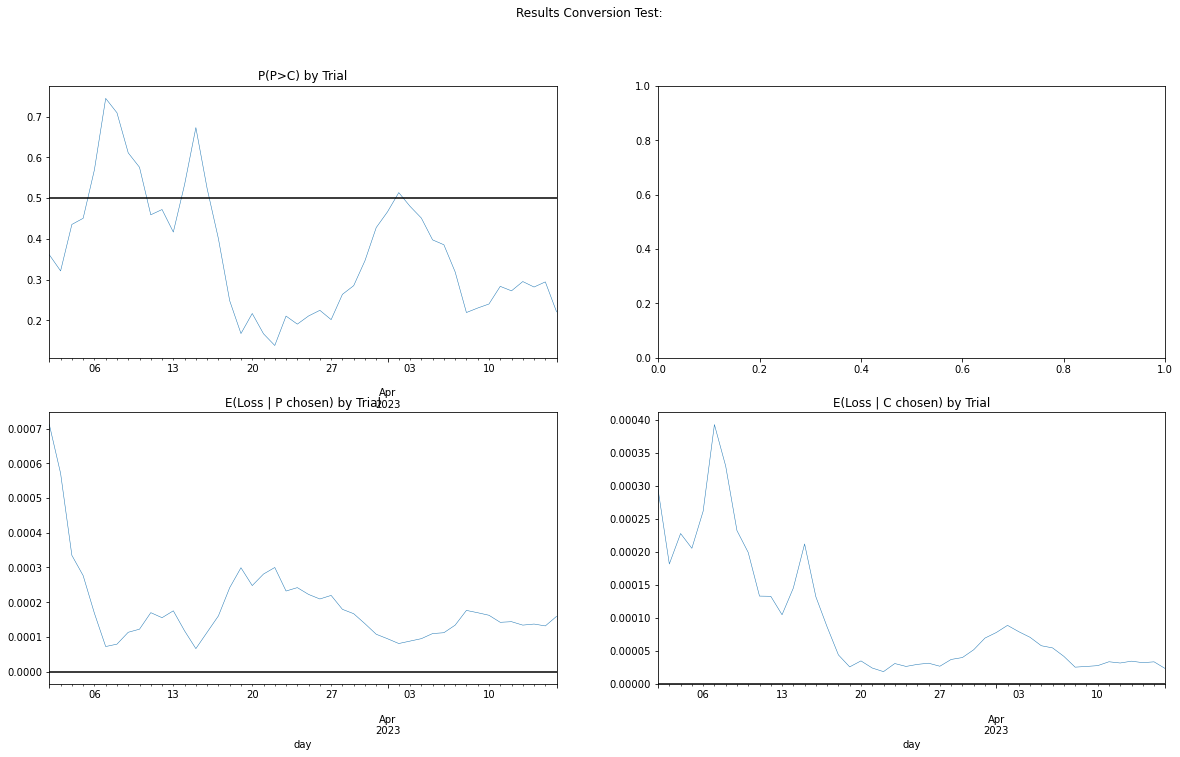

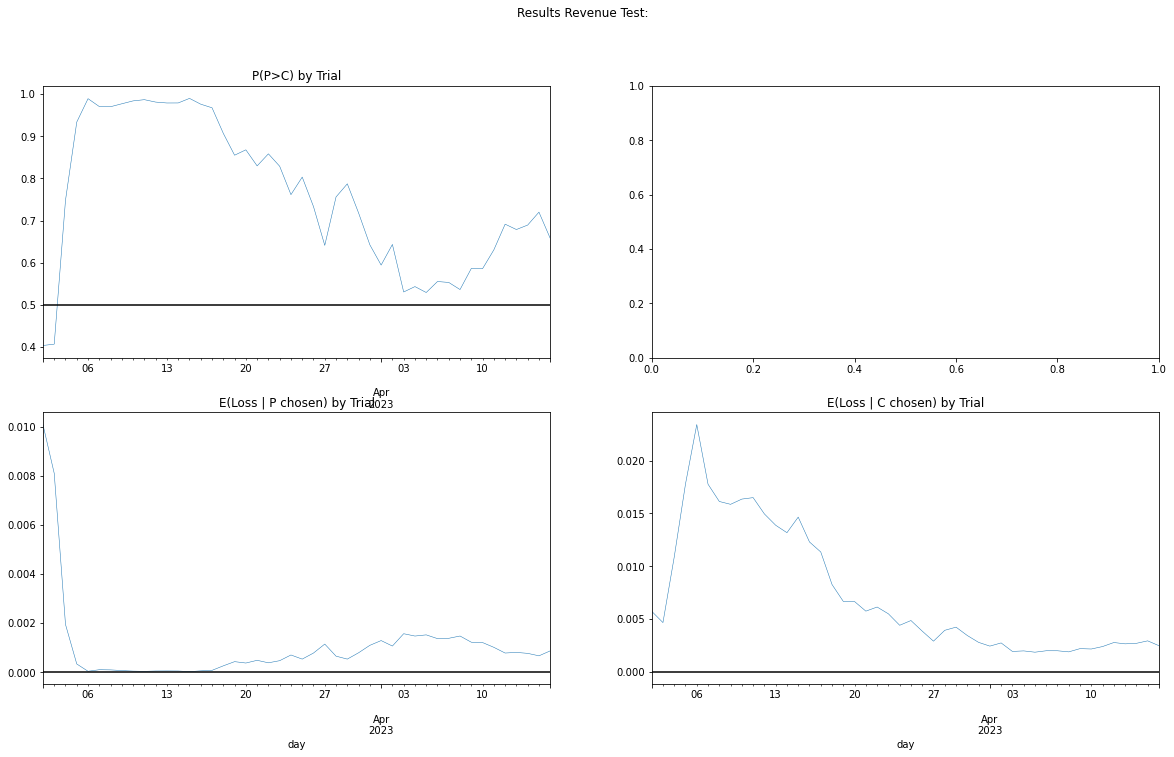

In [88]:
# This is used for the plotting, just a convenient way to store the test outputs and then plot them.

ba_eval_0 = pd.DataFrame(
    ba_eval[0],
    columns=[
        "trial",
        "day",
        "prob_being_best_p",
        "expected_loss_p",
        "prob_being_best_c",
        "expected_loss_c",
    ],
).dropna()
ba_eval_1 = pd.DataFrame(
    ba_eval[1],
    columns=[
        "trial",
        "day",
        "prob_being_best_p",
        "expected_loss_p",
        "prob_being_best_c",
        "expected_loss_c",
    ],
).dropna()


plot_results(ba_eval_0, "Conversion", stop_rule_con)
plot_results(ba_eval_1, "Revenue", stop_rule_rev)

**Example Interpretation:**

Conversion Test:
1) Inconclusive.
2) Inconclusive, however loss given C is lower than loss given P.

Revenue Test:
1) Inconclusive, however P(P>C) strictly > 0.5 after day 2.
2) Inconclusive, however loss given P is lower than loss given C.

### P_before vs P_now:

In [94]:
# Same thing as above but the query is more complex.
## BUT WE HAVE TO KEEP IN MIND WHICH TEST IS P & WHICH IS C!
## And we have to have the same number of days & shift the meta_dates accordingly.

ba_df = FeatureStoreOfflineClient.run_athena_query_pandas("""
SELECT user_id
     , meta_date
     , first_login
     , 'C'                          test_group
     , COALESCE(SUM(spend), 0)      total_spend
     , COALESCE(SUM(wins_spend), 0) total_wins_spend
FROM analytics__century_games_ncmgu__bingo_aloha_r3g9v.user_level_performance
WHERE meta_date >= DATE '2023-01-01'
  AND meta_date < DATE '2023-01-21'
  AND (fl_personalized_offer_spend <> 0 OR fl_personalized_offer_spend IS NULL)
GROUP BY user_id
       , meta_date
       , first_login
UNION
SELECT user_id
     , meta_date - INTERVAL '1' MONTH
     , first_login
     , 'P'                          test_group
     , COALESCE(SUM(spend), 0)      total_spend
     , COALESCE(SUM(wins_spend), 0) total_wins_spend
FROM analytics__century_games_ncmgu__bingo_aloha_r3g9v.user_level_performance
WHERE meta_date >= DATE '2023-02-01'
  AND meta_date < DATE '2023-02-21'
  AND (fl_personalized_offer_spend <> 0 OR fl_personalized_offer_spend IS NULL)
GROUP BY user_id
       , meta_date
       , first_login;
""")

ba_df.head()

2023-04-18 12:35:34,883 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


DummyStatsClient._send unknown.athena_query_runs_total:1|c
DummyStatsClient._send unknown.athena_query_queue_ms:153.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:5141.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:745597668|c


,user_id,meta_date,first_login,test_group,total_spend,total_wins_spend
0,178978622,2023-01-14,2022-01-22,P,0.00,0.00
1,237694552,2023-01-13,2022-06-23,P,0.00,0.00
2,219317722,2023-01-10,2022-04-28,P,0.00,0.00
3,239599340,2023-01-14,2022-02-20,P,0.00,0.00
4,344374161,2023-01-13,2022-12-26,P,24.96,24.96


In [95]:
## Sample Parameters:
data_mu = np.mean(ba_df[ba_df.total_wins_spend > 0].total_wins_spend)
data_var = np.var(ba_df[ba_df.total_wins_spend > 0].total_wins_spend)

## Method of Moments: <- input as m_prior for test
##                       Formula from wikipedia and definition of log_normal distribution.
##                       https://en.wikipedia.org/wiki/Log-normal_distribution#Arithmetic_moments
mm_mu = np.log(data_mu / np.sqrt(data_var/(data_mu**2) + 1))
mm_var = np.log(data_var/(data_mu*data_mu) + 1)

## Actual Parameters: <- Logic behind Method of Moments is that it gives parameters for distribution from sample parameters. Notice how actual = data.
#actual_mu = np.exp(mm_mu + mm_var/2)
#actual_var = (np.exp(1 - mm_var) * np.exp(2 * mm_mu + mm_var))

In [96]:
# Run the test using some basic priors @Kaja, and mm_mu found from data, selected stop rules, data frame containing data.

ba_eval = eval_data_seq(
    data_df = ba_df,
    stop_rule_con = stop_rule_con,
    stop_rule_rev = stop_rule_rev,
    a_prior_conv_test_C = 1,
    b_prior_conv_test_C = 1,
    a_prior_conv_test_P = 1,
    b_prior_conv_test_P = 1,
    a_prior_beta_revenue_test_P = 1,
    b_prior_beta_revenue_test_P = 1,
    m_prior_revenue_test_P = mm_mu,
    a_prior_ig_revenue_test_P = 10,
    b_prior_ig_revenue_test_P = 20,
    w_prior_revenue_test_P = 10,
    a_prior_beta_revenue_test_C = 1,
    b_prior_beta_revenue_test_C = 1,
    m_prior_revenue_test_C = mm_mu,
    a_prior_ig_revenue_test_C = 10,
    b_prior_ig_revenue_test_C = 20,
    w_prior_revenue_test_C = 10
)

2023-01-01 00:00:00
2023-01-02 00:00:00
2023-01-03 00:00:00
2023-01-04 00:00:00
2023-01-05 00:00:00
2023-01-06 00:00:00
2023-01-07 00:00:00
2023-01-08 00:00:00
2023-01-09 00:00:00
2023-01-10 00:00:00
2023-01-11 00:00:00
2023-01-12 00:00:00
2023-01-13 00:00:00
2023-01-14 00:00:00
2023-01-15 00:00:00
2023-01-16 00:00:00
2023-01-17 00:00:00
2023-01-18 00:00:00
2023-01-19 00:00:00
2023-01-20 00:00:00


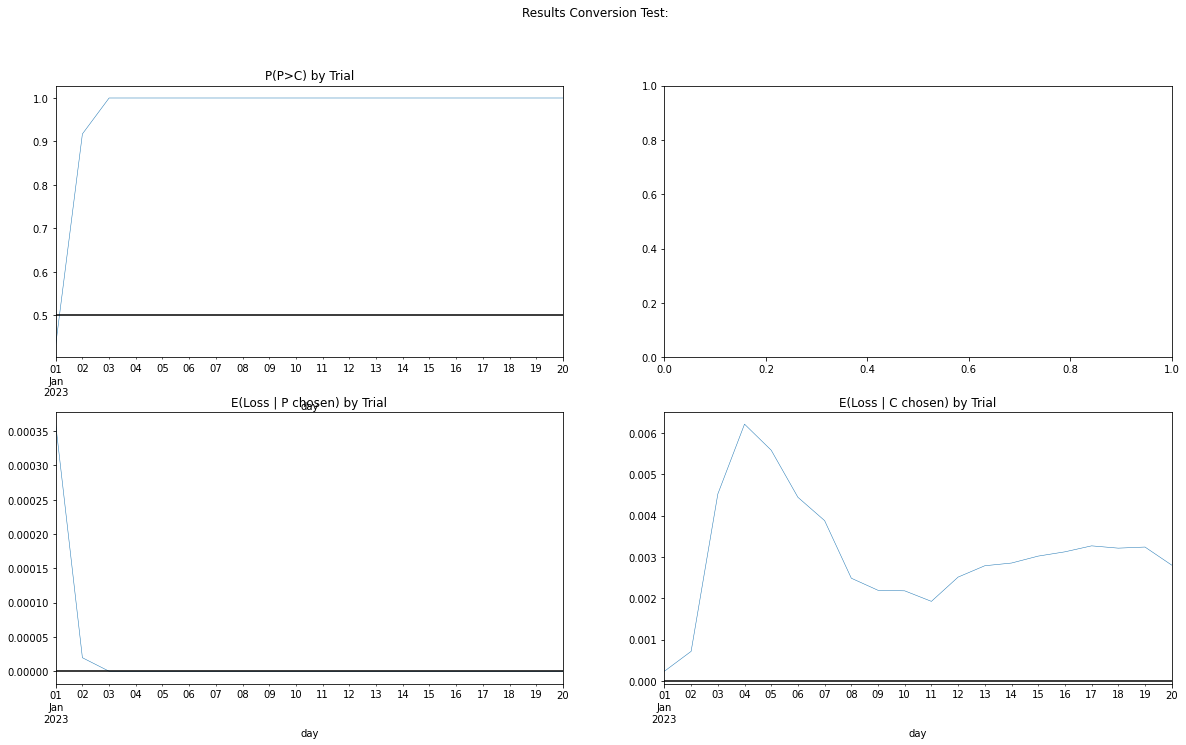

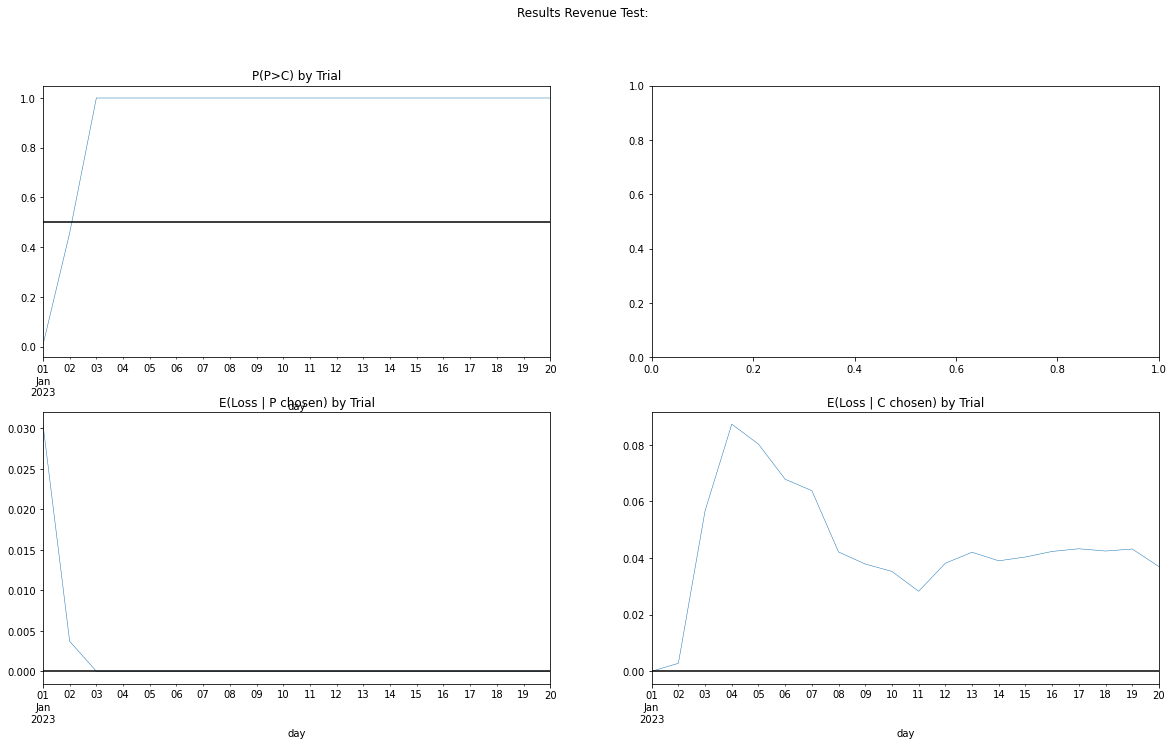

In [97]:
# This is used for the plotting, just a convenient way to store the test outputs and then plot them.

ba_eval_0 = pd.DataFrame(
    ba_eval[0],
    columns=[
        "trial",
        "day",
        "prob_being_best_p",
        "expected_loss_p",
        "prob_being_best_c",
        "expected_loss_c",
    ],
).dropna()
ba_eval_1 = pd.DataFrame(
    ba_eval[1],
    columns=[
        "trial",
        "day",
        "prob_being_best_p",
        "expected_loss_p",
        "prob_being_best_c",
        "expected_loss_c",
    ],
).dropna()


plot_results(ba_eval_0, "Conversion", stop_rule_con)
plot_results(ba_eval_1, "Revenue", stop_rule_rev)

**Example Interpretation:**

Conversion Test:
1) P>C given P(P>C) stayes at 100% after day 3.
2) As supporting evidence of above conclusion the E(Loss|P chosen) tends to 0 while its counterpart the E(Loss|C chosen) does not.
3) Given P is January data and C is February data, useres had higher conversion in January than in Ferbrary.

Revenue Test:
1) P>C given P(P>C) stayes at 100% after day 3.
2) As supporting evidence of above conclusion the E(Loss|P chosen) tends to 0 while its counterpart the E(Loss|C chosen) does not.
3) Given P is January data and C is February data, useres had higher performance in January than in Ferbrary.

## P_pers vs P_non_pers

In [98]:
# Same thing as above but the query is more complex.
## BUT WE HAVE TO KEEP IN MIND WHICH TEST IS P & WHICH IS C!

ba_df = FeatureStoreOfflineClient.run_athena_query_pandas("""
SELECT user_id
     , meta_date
     , first_login
     , 'C'                          test_group
     , COALESCE(SUM(spend), 0)      total_spend
     , COALESCE(SUM(wins_spend), 0) total_wins_spend
FROM analytics__century_games_ncmgu__bingo_aloha_r3g9v.user_level_performance
WHERE meta_date >= DATE '2023-01-01'
  AND meta_date < DATE '2023-01-21'
  AND group_tag = 'personalized'
  AND (fl_personalized_offer_spend <> 0 OR fl_personalized_offer_spend IS NULL)
GROUP BY user_id
       , meta_date
       , first_login
UNION
SELECT user_id
     , meta_date
     , first_login
     , 'P'                          test_group
     , COALESCE(SUM(spend), 0)      total_spend
     , COALESCE(SUM(wins_spend), 0) total_wins_spend
FROM analytics__century_games_ncmgu__bingo_aloha_r3g9v.user_level_performance
WHERE meta_date >= DATE '2023-01-01'
  AND meta_date < DATE '2023-01-21'
  AND group_tag = 'personalized'
  AND (fl_personalized_offer_spend <> 1 OR fl_personalized_offer_spend IS NULL)
GROUP BY user_id
       , meta_date
       , first_login;
""")

ba_df.head()

2023-04-18 12:39:06,557 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


DummyStatsClient._send unknown.athena_query_runs_total:1|c
DummyStatsClient._send unknown.athena_query_queue_ms:144.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:5087.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:774216996|c


,user_id,meta_date,first_login,test_group,total_spend,total_wins_spend
0,192297481,2023-01-11,2021-09-21,P,0.0,0.0
1,150403822,2023-01-04,2021-10-10,P,0.0,0.0
2,327623050,2023-01-14,2022-11-11,P,0.0,0.0
3,215878382,2023-01-02,2022-04-19,P,0.0,0.0
4,279078760,2023-01-18,2022-05-29,P,0.0,0.0


In [99]:
## Sample Parameters:
data_mu = np.mean(ba_df[ba_df.total_wins_spend > 0].total_wins_spend)
data_var = np.var(ba_df[ba_df.total_wins_spend > 0].total_wins_spend)

## Method of Moments: <- input as m_prior for test
##                       Formula from wikipedia and definition of log_normal distribution.
##                       https://en.wikipedia.org/wiki/Log-normal_distribution#Arithmetic_moments
mm_mu = np.log(data_mu / np.sqrt(data_var/(data_mu**2) + 1))
mm_var = np.log(data_var/(data_mu*data_mu) + 1)

## Actual Parameters: <- Logic behind Method of Moments is that it gives parameters for distribution from sample parameters. Notice how actual = data.
#actual_mu = np.exp(mm_mu + mm_var/2)
#actual_var = (np.exp(1 - mm_var) * np.exp(2 * mm_mu + mm_var))

In [100]:
# Run the test using some basic priors @Kaja, and mm_mu found from data, selected stop rules, data frame containing data.

ba_eval = eval_data_seq(
    data_df = ba_df,
    stop_rule_con = stop_rule_con,
    stop_rule_rev = stop_rule_rev,
    a_prior_conv_test_C = 1,
    b_prior_conv_test_C = 1,
    a_prior_conv_test_P = 1,
    b_prior_conv_test_P = 1,
    a_prior_beta_revenue_test_P = 1,
    b_prior_beta_revenue_test_P = 1,
    m_prior_revenue_test_P = mm_mu,
    a_prior_ig_revenue_test_P = 10,
    b_prior_ig_revenue_test_P = 20,
    w_prior_revenue_test_P = 10,
    a_prior_beta_revenue_test_C = 1,
    b_prior_beta_revenue_test_C = 1,
    m_prior_revenue_test_C = mm_mu,
    a_prior_ig_revenue_test_C = 10,
    b_prior_ig_revenue_test_C = 20,
    w_prior_revenue_test_C = 10
)

2023-01-01 00:00:00
2023-01-02 00:00:00
2023-01-03 00:00:00
2023-01-04 00:00:00
2023-01-05 00:00:00
2023-01-06 00:00:00
2023-01-07 00:00:00
2023-01-08 00:00:00
2023-01-09 00:00:00
2023-01-10 00:00:00
2023-01-11 00:00:00
2023-01-12 00:00:00
2023-01-13 00:00:00
2023-01-14 00:00:00
2023-01-15 00:00:00
2023-01-16 00:00:00
2023-01-17 00:00:00
2023-01-18 00:00:00
2023-01-19 00:00:00
2023-01-20 00:00:00


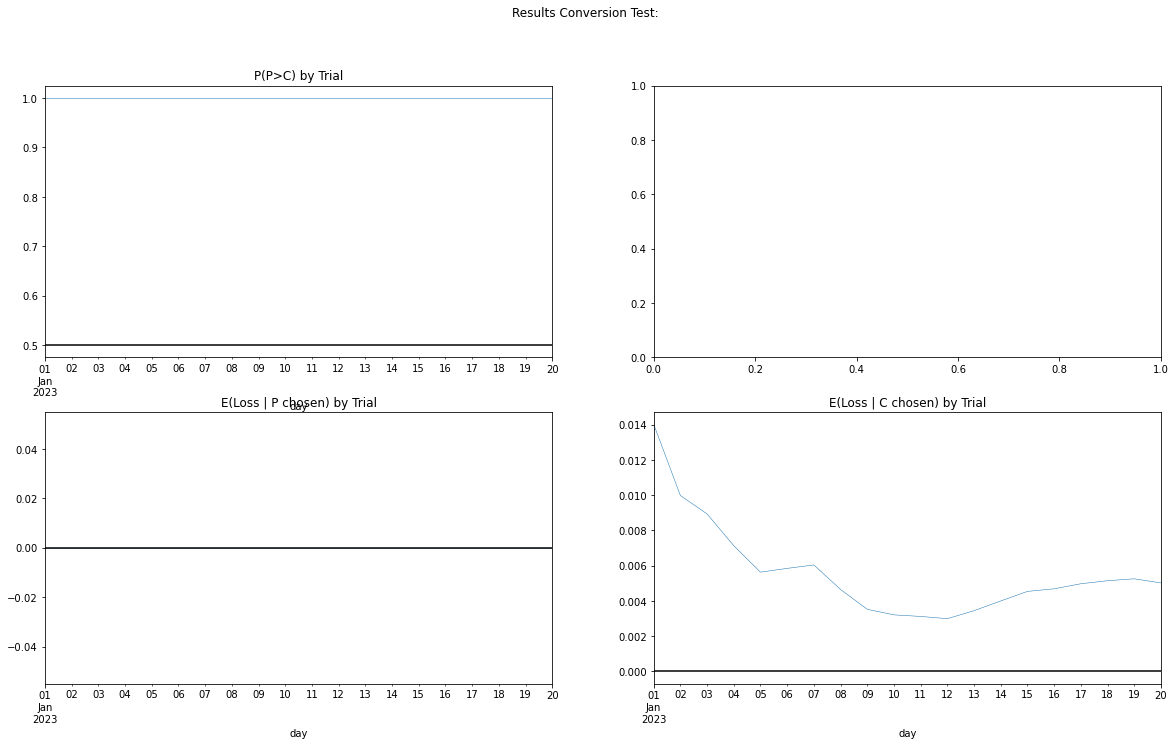

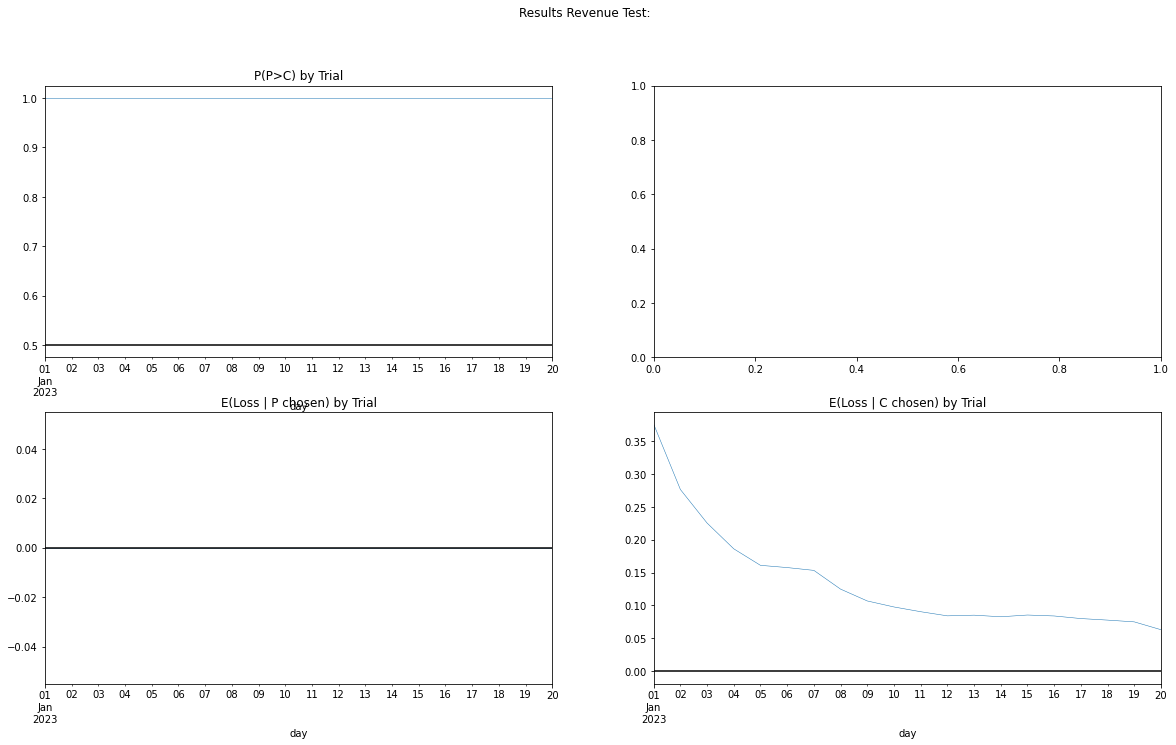

In [101]:
# This is used for the plotting, just a convenient way to store the test outputs and then plot them.

ba_eval_0 = pd.DataFrame(
    ba_eval[0],
    columns=[
        "trial",
        "day",
        "prob_being_best_p",
        "expected_loss_p",
        "prob_being_best_c",
        "expected_loss_c",
    ],
).dropna()
ba_eval_1 = pd.DataFrame(
    ba_eval[1],
    columns=[
        "trial",
        "day",
        "prob_being_best_p",
        "expected_loss_p",
        "prob_being_best_c",
        "expected_loss_c",
    ],
).dropna()


plot_results(ba_eval_0, "Conversion", stop_rule_con)
plot_results(ba_eval_1, "Revenue", stop_rule_rev)

**Example Interpretation:**

Conversion Test:
1) P>C given P(P>C) stayes at 100% from initiation.
2) As supporting evidence of above conclusion the E(Loss|P chosen) is at 9 while its counterpart the E(Loss|C chosen) is > 0.
3) Given P is all data and C is personalised data, useres had higher conversion in all_data than in personalised data.

Revenue Test:
1) P>C given P(P>C) stayes at 100% from initiation.
2) As supporting evidence of above conclusion the E(Loss|P chosen) is at 9 while its counterpart the E(Loss|C chosen) is > 0.
3) Given P is all data and C is personalised data, useres had higher performance in all_data than in personalised data.